# Retrievals: Basic Retrieval Tutorial

Written by [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals).
Please cite pRT's retrieval package [(Nasedkin et al. 2024)](https://ui.adsabs.harvard.edu/abs/2024JOSS....9.5875N/abstract) in addition to pRT [(Mollière et al. 2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..67M/abstract) if you make use of the retrieval package for your work.

**What is a retrieval?**

Let's start with the basics! 
An atmospheric retrieval is the process through which we fit a model of a spectrum to data. In the exoplanet community this usually means Bayesian model fitting, for which you can find an introduction [here](https://www2.mpia-hd.mpg.de/~molliere/grad_days/Retrievals_Bayesian_model_fitting.html). The model usually incorporates elements of chemistry and radiative transfer in order to compute a spectrum - see the [getting started page for an example](./getting_started.ipynb).

If you're here, we're going to assume that you already have an exoplanet emission or transmission spectrum, and you want to learn something about the planet's properties. 
We'll pRT spectral modeling capabilities combined with a sampler which will allow us to statistically measure the properties of the planet of interest.
As inputs for this, you'll need a 1D spectrum with error bars (or a covariance matrix), and a model function that generates a synthetic spectrum. 
We have a few example datasets included in [petitRADTRANS/retrieval/examples/](https://gitlab.com/mauricemolli/petitRADTRANS/-/tree/master/petitRADTRANS/retrieval/examples), and several forward models implemented in [petitRADTRANS/retrieval/models.py](https://gitlab.com/mauricemolli/petitRADTRANS/-/blob/master/petitRADTRANS/retrieval/models.py), which you can use directly, or as templates to build your own model. These files are included in the pRT package folder. Alternatively you can access them through the git links (just click on the folder / file names above).

In this example we will make use of an HST transmission spectrum, located locally in `petitRADTRANS/retrieval/examples/transmission/observations/HST/hst_example_clear_spec.txt`, or, again, [on git](https://gitlab.com/mauricemolli/petitRADTRANS/-/tree/master/petitRADTRANS/retrieval/examples/transmission/observations/HST/hst_example_clear_spec.txt). This dataset is included when you install pRT, and we'll automatically locate the data and output files throughout the notebook.
The outputs of the retrieval example will be a best-fit spectrum, an atmospheric pressure-temperature profile, and the posterior distributions of all of the parameters of your model atmosphere.
Of course, you do not have to use pRT's retrieval package to run retrievals with pRT-generated spectra, but we believe that what is described below may be sufficient for most people, and will thus save you from most of the tedious implementation work.

## Getting started


You should already have an installation of pRT on your machine; please see the [installation manual](../installation.rst) if you have not installed it yet. As mentioned on the installation page,
pyMultiNest - and therefore Multinest, which implements a special form of [nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm), are also required.
`Multinest` allows for easy parallelization of the retrievals when run on large clusters, but can also be installed locally on your laptop to run small retrievals, such as our example here [(you can also parallelize your runs then)](https://johannesbuchner.github.io/PyMultiNest/pymultinest.html#using-pymultinest-with-mpi).
[Ultranest](https://johannesbuchner.github.io/UltraNest/index.html) is required if you want to use that as your sampler rather than pyMultiNest. 
See the Ultranest documentation for why you might want to choose this method.
Using nested sampling rather than, for example, [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) is often faster, handles multimodal cases better, and directly provides the Bayesian evidence, which allows for easier model comparison.
Again, see [here](https://www2.mpia-hd.mpg.de/~molliere/grad_days/Retrievals_Bayesian_model_fitting.html) if you need an introduction to Bayesian model fitting and its terminology.
We've also found that in pyMultinest is often faster than Ultranest, and generally recommend its use.

In this tutorial, we will outline the process of setting up a RetrievalConfig object, which is the class used to set up a pRT retrieval.
The basic process will always be to set up the configuration, and then pass it to the Retrieval class to run the retrieval using pyMultiNest.
Several standard plotting outputs will also be produced by the retrieval class.
Most of the classes and functions used in this tutorial have more advanced features than what will be explained here, so it's highly recommended to take a look at the code and API documentation. 
There should be enough flexibility built in to cover most typical retrieval studies, but if you have feature requests please get in touch, or open an issue on [gitlab](https://gitlab.com/mauricemolli/petitRADTRANS/-/issues).



In [1]:
# Let's start by importing everything we need.
import os
# To not have numpy start parallelizing on its own when using MPI, OpenMP, mpi4py
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

from petitRADTRANS import physical_constants as cst

# Import the class used to set up the retrieval.
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
# Import Prior functions, if necessary.
from petitRADTRANS.retrieval.utils import gaussian_prior
# Import an atmospheric model function
from petitRADTRANS.retrieval.models import isothermal_transmission

Let's start with a simple model. 
We'll use an isothermal temperature profile, and use "free chemistry" - allowing the chemical abundances to vary freely within fixed boundaries, but requiring them to be vertically constant throughout the atmosphere.
The basic process for every retrieval will be the same. We need to set up a [RetrievalConfig](https://gitlab.com/mauricemolli/petitRADTRANS/-/blob/master/petitRADTRANS/retrieval/retrieval_config.py) object, adding in the [Data](https://gitlab.com/mauricemolli/petitRADTRANS/-/blob/master/petitRADTRANS/retrieval/data.py) objects that we want to fit together with the [Parameter](https://gitlab.com/mauricemolli/petitRADTRANS/-/blob/master/petitRADTRANS/retrieval/parameter.py) objects and their priors, which we can use to customize our retrieval.


### Retrieval configuration object and parameters

Let's start out by setting up a simple run definition.
We'll add the data **AFTER** we define the model function below.
We start out by initialising the `RetrievalConfig` object (which we call ``retrieval_config`` here), and then adding each of the parameters of interest to it.

Each parameter must be given a name, which matches the name used in the model function defined below.
Parameters can be set to fixed or free. Fixed parameters must be given a value, while free parameters are given a function that transforms the unit hypercube generated by multinest into physical prior space. Various prior functions are stored in ``retrieval.utils``, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/utils/index.html).
Full details of the parameters can be found in the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval_config/index.html).

In [2]:
# Lets start out by setting up a simple run definition
# We'll add the data AFTER we define the model function below
# Full details of the parameters can be found in retrieval_config.py

# If our retrieval has already run before, you can set the run_mode to 'evaluate' to only make some plots.
retrieval_config = RetrievalConfig(
    retrieval_name="hst_example_clear_spec",
    run_mode="retrieve",  # this can be 'evaluate' to get the results of a retrieval
    amr=False, # We won't be using adaptive mesh refinement for the pressure grid        
    scattering_in_emission=False # This would turn on scattering when calculating emission spectra (always activated in transmission).
)
    
# Let's start with the parameters that will remain fixed during the retrieval
retrieval_config.add_parameter(
    'stellar_radius', # name
    False,   # is_free_parameter, so stellar_radius is not retrieved here.
    value = 0.651*cst.r_sun
)

# Log of the surface gravity in cgs units.
# The transform_prior_cube_coordinate function transforms a uniform random sample x, drawn between 0 and 1.
# to the physical units we're using in pRT. We use Python's lambda functions here.
retrieval_config.add_parameter(
    'log_g',
    True, # is_free_parameter: we are retrieving log(g) here 
    transform_prior_cube_coordinate=lambda x : 2.+3.5*x  # this means that log g can vary between 2 and 5.5
)
# Note that logg is usually not a free parameter in retrievals of
# transmission spectra, at least it is much better constrained as being
# assumed here, as the planetary mass and radius are usually known.

# Planet radius in cm
retrieval_config.add_parameter(
    'planet_radius', 
    True,
    transform_prior_cube_coordinate=lambda x : ( 0.2+0.2*x)*cst.r_jup_mean  # radius varies between 0.2 and 0.4 R_jup
)

# Atmospheric temperature in Kelvin
retrieval_config.add_parameter(
    'temperature', 
    True,
    transform_prior_cube_coordinate = lambda x : 300.+2000.*x
)

# Let's include a grey cloud as well to see what happens, even though we assumed a clear atmosphere.
retrieval_config.add_parameter(
    "log_Pcloud", 
    True, 
    transform_prior_cube_coordinate = \
    lambda x : -6.0+8.0*x                                 # the atmosphere can thus have an opaque cloud between 1e-6 and 100 bar
)

## Opacities

petitRADTRANS can be setup to use line-by-line opacities at $\lambda/\Delta \lambda = 10^6$, or a lower resolution correlated-k mode (which we use here). The names of each species must follow the naming convention explained [here](../available_opacities.html), which also contains a list of available species. ['Getting Started'](getting_started.html) also has an example for how to load opacities in pRT.

In addition to line opacities, pRT can also include, for example, Rayleigh scattering, collision-induced absorption (CIA) opacities, or opacities for various condensate cloud species. Again, see [here](../available_opacities.html) for a list. If a cloud species is used, it will have a set of parameters added in order to retrieve the cloud abundance. We give such an example below. The parameters added depend on the model chosen.

If you aren't sure which species are available, the RetrievalConfig class has a few functions that will list the currently available line, CIA and cloud opacities, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval_config/index.html).

### Opacity resolution

Do not append resolution identifiers, for example ``.R100``, to the species name, if you want to use a correlated-k species at lower resolution of $\lambda/\Delta \lambda = 100$, instead of the nominal $\lambda/\Delta \lambda = 1000$. Instead, you will specify a model resolution when adding data (see below). If you set the model resolution for your data, and do not have existing c-k tables at that resolution, [Exo_k](https://perso.astrophy.u-bordeaux.fr/~jleconte/exo_k-doc/index.html) will be used to bin the higher resolution tables down to a lower resolution. Please cite Exo_k and the corresponding paper [(Leconte et al. 2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..20L/abstract) if you make use of this functionality in pRT.

You can use ``retrieval_config.list_available_line_species()`` to see which line species are availble on your machine, but note that pRT will automatically download those listed [here](../available_opacities.html) if you request some that you do not have yet.

Let's add some opacities below now:

In [3]:
retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(['H2-H2', 'H2-He'])

# Here we setup the line species for a free retrieval,
# setting the prior bounds of the log10 abundance with the abund_lim parameter
# So the retrieved value is the log mass fraction.
retrieval_config.set_line_species(
    [
        'H2O__POKAZATEL',
        'CH4__HITEMP',
        'CO2',
        'CO-NatAbund__HITEMP'
    ],
    eq=False,
    abund_lim = (-6.0,0.0)
)

## Model Functions


In addition to setting up a retrieval with a standard model, you may also want to write your own model to be used in the retrieval setup.
`pRT` has a wide range of built in model functions, which we recommend using as opposed to writing your own, but we'll include a simple example here to show what's going on behind the scenes.
For further documentation on the built in models, [check out this tutorial page.](./retrieval_models.html)
This function will be passed as the ``model_generating_function`` argument when you ``add_data()`` to the object of the ``RetrievalConfig`` class. Here we will demonstrate howe to define a simple, cloud-free transmission spectrum model using free retrieval chemistry and an isothermal P-T profile.

Four parameters are required for the function definition of the model. A pRT object which is created is from the `Radtrans` class in pRT (the retrieval package will handle this) and a dictionary of parameters, which is stored in the RetrievalConfig class that we defined above. The remaining three parameters deal with plotting and adaptive mesh refinement, which we won't use in this example.

In general, the built-in model functions require cgs units, apart from pressure which is given in bar.

For this tutorial we are reimplementing a simplified version the `isothermal_transmission` model, available in `petitRADTRANS.retrieval.models`. 

In [4]:
from petitRADTRANS.physics import temperature_profile_function_isothermal
from petitRADTRANS.chemistry.utils import compute_mean_molar_masses
from petitRADTRANS.retrieval.models import _compute_gravity

# Now we can define the atmospheric model we want to use
def retrieval_model_spec_iso(
    prt_object,
    parameters,
    pt_plot_mode=False,
    amr=False
):
    """
    retrieval_model_eq_transmission
    This model computes a transmission spectrum based on free retrieval chemistry
    and an isothermal temperature-pressure profile. 
    
    parameters
    -----------
    pRT_object : object
        An instance of the pRT class, with optical properties as defined in the RunDefinition.
    parameters : dict
        Dictionary of required parameters:
            Rstar : Radius of the host star [cm]
            log_g : Log of surface gravity
            R_pl : planet radius [cm]
            temperature : Isothermal temperature [K]
            species : Log abundances for each species used in the retrieval
            log_Pcloud : optional, cloud base pressure of a grey cloud deck.
    PT_plot_mode : bool
        Return only the pressure-temperature profile for plotting. Evaluate mode only.
    AMR : 
        Adaptive mesh refinement. Use the high resolution pressure grid around the cloud base.

    returns
    -------
    wlen_model : np.array
        Wavlength array of computed model, not binned to data [um]
    spectrum_model : np.array
        Computed transmission spectrum R_pl**2/Rstar**2
    """
    contribution = False
    if "contribution" in parameters.keys():
        contribution = parameters["contribution"].value

    # Make the P-T profile
    pressures = prt_object._pressures / 1e6 # Convert from cgs to bar; internally pRT uses cgs
    p_reference = 0.01 # reference pressure in bar, can also be a retrieved parameter

    # Note how we access the values of the Parameter class objects
    temperatures = temperature_profile_function_isothermal(pressures,
                                                           parameters['temperature'].value)
    # alternatively you could just do
    # temperatures = np.ones_like(pressures) * parameters['temperature'].value
       
    # If in evaluation mode, and PTs are supposed to be plotted
    if pt_plot_mode:
        return pressures, temperatures
    
    # Make the abundance profiles
    mass_fractions = {}
    msum = 0.0 # Check that the total massfraction of all species is <1
    
    for species in prt_object.line_species:
        spec = species.split('.R')[0] # Dealing with the naming scheme
                                       # for binned down opacities (see below).
        mass_fractions[species] = 10**parameters[spec].value * np.ones_like(pressures)
        msum += 10**parameters[spec].value
    
    if msum > 1.0:
        return None, None

    mass_fractions['H2'] = 0.766 * (1.0-msum) * np.ones_like(pressures)
    mass_fractions['He'] = 0.234 * (1.0-msum) * np.ones_like(pressures)
    
    # Find the mean molecular weight in each layer
    mean_molar_masses = compute_mean_molar_masses(mass_fractions)
    
    gravity, planet_radius =  _compute_gravity(parameters)

    # Calculate the spectrum
    results = prt_object.calculate_transit_radii(
            temperatures=temperatures,
            mass_fractions=mass_fractions,
            reference_gravity=gravity,
            mean_molar_masses=mean_molar_masses,
            planet_radius=planet_radius,
            reference_pressure=p_reference,
            return_cloud_contribution=contribution,
            opaque_cloud_top_pressure=1e1**parameters['log_Pcloud'].value,
            return_contribution=contribution,
            frequencies_to_wavelengths=True
        )
                           
    if not contribution:
        wavelengths, transit_radii, _ = results
        additional_output = None
    else:
        wavelengths, transit_radii, additional_output = results

    wlen_model = wavelengths * 1e4 # convert to micron
    spectrum_model = (transit_radii / parameters['stellar_radius'].value) ** 2.

    if contribution:
        return wlen_model, spectrum_model, additional_output['transmission_contribution']
    
    return wlen_model, spectrum_model

## Data

With the model set up, we can read in the data. The data must be a 1D spectrum with error bars or a covariance matrix.
The input format for ASCII data is
```
# Wavelength [micron], Flux [W/m2/micron or (Rp/Rstar)^2], Flux Error [W/m2/micron or (Rp/Rstar)^2]
```
Optionally, there can also be an additional column to specify the wavelength bins, which would then have the format:
```
# Wavelength [micron], Bins [micron], Flux [W/m2/micron or (Rp/Rstar)^2], Flux Error [W/m2/micron or (Rp/Rstar)^2]
```
The file can be comma or space separated, and by default '#' is the comment character.
The wavelength column must be sorted and is in ascending order.
**If you write your own model function, the units of your data can vary from this template, but the units of your data and the output of your model function must match.**
Throughout our documentation we will use W/m^2/micron for emission spectra and (Rp/Rstar)^2 for consistency between our model functions and the example data.

The fits file requirements are more strict.
An extension labelled 'SPECTRUM' is required, with three fields in a binary table: 'WAVELENGTH', 'FLUX' and 'COVARIANCE'.
An example of this is the `HR8799e_spectra.fits` file included in `petitRADTRANS/retrieval/examples/emission/`, see [pRT's gitlab page](https://gitlab.com/mauricemolli/petitRADTRANS/-/blob/master/petitRADTRANS/retrieval/examples/emission/observations/HR8799e_Spectra.fits).
If your file is not of that format, but you want to add a covariance matrix, you could also fill in these attributes of the data object that gets added to the retrieval configuration after calling ``add_data()``:

- ``covariance``: the covariance matrix
- ``inv_cov``: the inverse of the covariance matrix
- ``log_covariance_determinant``: the natural logarithm of the derterminant of the covariance matrix

The Data class is arguably the most important part of setting up the retrieval. 
Not only do you input your data here, but you also choose your model function and resolution.
This means that you can design a retrieval around different datatypes and retrieve simultaneously on both - for example, if you want the day and nightside of a planet, or want to combine the eastward and westward limbs of a transmission spectrum with different models. 

By adjusting the resolution you can also speed up the retrieval. By default, pRT uses the correlated-k method for computing opacities, which works up to $\lambda/\Delta \lambda = 1000$. Here you need to pick `'c-k'` as `line_opacity_mode`, see below. Often low resolution data does not require this resolution, and the computation can be sped up using the ``model_resolution parameter``, which will use the Exo-k package to bin down the correlated-k tables.

If you use the `'lbl'` (line-by-line) mode, pRT can uses opacities up to $\lambda/\Delta \lambda = 10^6$, though this is quite slow and memory intensive. By setting the ``model_resolution`` parameter, pRT will sample the high resolution line list at the specified resolution (e.g., ``model_resolution=10**5.`` will down-sample by a factor of 10). In this case you must make sure that the down-sampled calculations match the binned-down results of the $\lambda/\Delta \lambda = 10^6$ mode at the required data resolution (i.e., sampling can introduce noise and you have to test for that).

The Data class can also handle photometric data, which is described in the [emission tutorial](./retrieval_emission.html).

In [5]:
# Finally, we associate the model with the data, and we can run our retrieval!

# Here we import petitRADTRANS to find the path of the example files on your machine.
# In general this is not required, you just put the files in the folder that you are running
# Your script in, for example.
import petitRADTRANS # need to get the name for the example data

path_to_data = './' # Default location for the example
retrieval_config.add_data(
    'HST',  # simulated HST data
    f"{path_to_data}retrievals/transmission/observations/HST/hst_example_clear_spec.txt", # where is the data
    model_generating_function = retrieval_model_spec_iso, # the atmospheric model to use
    line_opacity_mode='c-k',
    data_resolution=60, # the spectral resolution of the data
    model_resolution=120  # the resolution of the c-k tables for the lines
) 
# This model is a noise-free, clear atmosphere transmission spectrum for a sub-neptune type planet
# The model function used to calculate it was slightly different, and used different opacity tables
# than what we'll use in the retrieval, but the results don't significantly change.
# You could even see it as a simulation of reality since we never have the perfect model or opacities
# that "Nature" is using.
#
# In general, it is also necessary to use the data_resolution and model_resolution arguments.
# The data_resolution argument will convolve the generated model spectrum by the instrumental 
# resolution before to calculating the chi squared value. As mentioned at the bottom of
# "Rebinning opacities", the model resolution should be >= 2 times larger than the data resolution.
#
# The model_resolution parameter will cause pRT to use exo-k to generate low-resolution correlated-k opacity tables
# in order to speed up the radiative transfer calculations (if this has not been done yet).

## Plotting

Let's also set up some plotting details so that we can generate nice outputs after the retrieval has finished.

Each parameter can be added to the corner plot, its label changed, and the values transformed to more digestible units (e.g., the planet radius in jupiter radii, rather than cm).
We can also set the bounds and scaling on the best-fit spectrum plot and the limits for the P-T profile plot.
With this complete, our retrieval is ready to go.

Most parameters include a default setting, so the plots will be created even if you don't set any plotting parameters, but the outputs might not be very informative. In general, the possible arguments to `plot_kwargs` follow the naming conventions of matplotlib arguments and functions, with some additions.
Full details of the plotting can be found in the Retrieval class, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval/index.html).

In [6]:
# Define what to put into corner plot if run_mode == 'evaluate'
retrieval_config.parameters['planet_radius'].plot_in_corner = True
retrieval_config.parameters['planet_radius'].corner_label = r'$R_{\rm P}$ ($\rm R_{Jup}$)'
retrieval_config.parameters['planet_radius'].corner_transform = lambda x : x/cst.r_jup_mean
retrieval_config.parameters['planet_radius'].corner_ranges = (0,2)

retrieval_config.parameters['log_g'].plot_in_corner = True
retrieval_config.parameters['log_g'].corner_ranges = (2., 5.)
retrieval_config.parameters['log_g'].corner_label = "log g"
retrieval_config.parameters['temperature'].plot_in_corner = True
retrieval_config.parameters['temperature'].corner_label ="Temp"
retrieval_config.parameters['temperature'].corner_ranges = (0,1500)
retrieval_config.parameters['log_Pcloud'].plot_in_corner = True
retrieval_config.parameters['log_Pcloud'].corner_label =r"log P$_{\rm cloud}$"
retrieval_config.parameters['log_Pcloud'].corner_ranges = (-6, 2)


# Adding all of the chemical species in our atmosphere to the corner plot
for spec in retrieval_config.line_species:
    retrieval_config.parameters[spec].plot_in_corner = True
    retrieval_config.parameters[spec].corner_ranges = (-6.2,0.2)

    # Note, the post_equal_weights file has the actual abundances.
    # If the retrieval is rerun, it will contain the log10(abundances)
    #retrieval_config.parameters[spec].corner_transform = lambda x : np.log10(x)

# Define axis properties of spectral plot if run_mode == 'evaluate'
retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
retrieval_config.plot_kwargs["nsample"] = 10

# Define from which observation object to take P-T in evaluation mode (if run_mode == 'evaluate'),
# add PT-envelope plotting options
retrieval_config.plot_kwargs["take_PTs_from"] = 'HST' 
retrieval_config.plot_kwargs["temp_limits"] = [150, 3000]
retrieval_config.plot_kwargs["press_limits"] = [1e1, 1e-6]

# If in doubt, define all of the plot_kwargs used here.

## Running the retrieval

At this point, we are almost ready to run the retrieval! We only need to do is pass the ``RunDefinition`` object  "``retrieval_config``" we just created to an object of the `Retrieval` class first.

In [7]:
output_directory = f"./retrievals/runs"

retrieval = Retrieval(
    retrieval_config,
    output_directory=output_directory,
    use_mpi = False,  # run locally, don't need to use MPI for massive parallelisation   
    evaluate_sample_spectra=False,  # output the spectrum from nsample random samples.                     
    use_prt_plot_style=True,  # we think that our plots look nice.
    ultranest=False  # let's use pyMultiNest rather than Ultranest
)

Setting up Radtrans object for data 'HST'...
Loading Radtrans opacities...
 Loading line opacities of species 'H2O__POKAZATEL.R120' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R120_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4__HITEMP.R120' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R120_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2.R120' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R120_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund__HITEMP.R120' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R120_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2

Now, we can call the `retrieval.run()` method and run the retrieval! 

<div class="alert alert-info">
    
There are a few additional parameters that can be adjusted, but the defaults should work well for almost all use cases. In general it may not be wise to run a retrieval on your laptop, as it can be quite computationally expensive. However, the included HST example should be able to be run fairly easily! (minutes!).
We only use 40 live points in the example so that it runs in a reasonable length of time, but we highly recommend using more live points for your own retrievals!
If you want to run the retrieval on a cluster, or just on multiple cores on your local machine, set `use_MPI=True`.
You should copy the contents of this notebook into a single `.py` file, which then you can run using `mpiexec -n $NUMBER_OF_CORES python my_retrieval_file.py`, substituting in the number of cores you want to use to run the retrieval.
Most of the various parameters used to control pyMultiNest or Ultranest can be set in the `retrieval.run()` function, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval/index.html).
</div>

In [8]:
%%time
retrieval.run(
    n_live_points=40,  # number of live points, 400 is good for small retrievals, 4000 for large ones
    const_efficiency_mode=False,  # turn constant efficiency mode on or off (recommend on for large retrievals)
    resume=False,  # if True, continue retrieval from where it left off
    seed=12345  # ⚠️ seed should be removed or set to -1 in a real retrieval, it is added here for reproducibility
)

Starting retrieval hst_example_clear_spec
Testing data 'HST':
 wavelengths:
  OK (no NaN, infinite, or negative value detected)
 spectrum:
  OK (no NaN, infinite, or negative value detected)
 uncertainties:
  OK (no NaN, infinite, or negative value detected)
Testing model function for data 'HST'...
No errors detected in the model functions!
Starting retrieval: hst_example_clear_spec

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =   40
 dimensionality =    8
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.756303
Replacements:                                 90
Total Samples:                               119
Nested Sampling ln(Z):               -610.944962
Importance Nested Sampling ln(Z):     126.833094 +/-  0.986291
Acceptance Rate:                  

Once the retrieval is complete, we can use several functions to generate plots of the best fit spectrum, the pressure-temperature profile and the corner plots.
A standard output file will be produced when the retrieval is run, describing the prior boundaries, the data used in the retrieval, and if the retrieval is finished it will include the best fit and median model parameters.
Check out this file, together with the other outputs in `./retrievals/runs/evaluate_hst_example_clear_spec`.

Let's make some plots to see how our retrieval went! We need to start by reading in the results.
If we want to read results from multiple retrievals, use the `ret_names` argument. Currently, only 
the corner plots make use of this feature.

In [9]:
# These are dictionaries in case we want to look at multiple retrievals.
# The keys for the dictionaries are the retrieval_names
sample_dict, parameter_dict = retrieval.get_samples(output_directory=output_directory)

# Pick the current retrieval to look at. 
samples_use = sample_dict[retrieval.configuration.retrieval_name]
parameters_read = parameter_dict[retrieval.configuration.retrieval_name]

### Best Fit Spectrum
Here we will plot the best fit spectrum, together with the data used in the retrieval and the residuals between the two. 
Using the `mode` parameter, it is also possible to plot the spectrum using the `'median'` fit instead of the maximum likelihood sample.
The chi squared value presented in the figure is the reduced chi square, that is the chi square divided by the degrees of freedom (number of data points - number of parameters).


Not in evaluate mode. Changing run mode to evaluate.

Plotting Best-fit spectrum
Best fit likelihood = 172.32
Loading Radtrans opacities...
 Loading line opacities of species 'H2O__POKAZATEL' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4__HITEMP' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund__HITEMP' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded al

/mnt/c/Users/doria/OneDrive/Documents/programs/Python/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:4374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


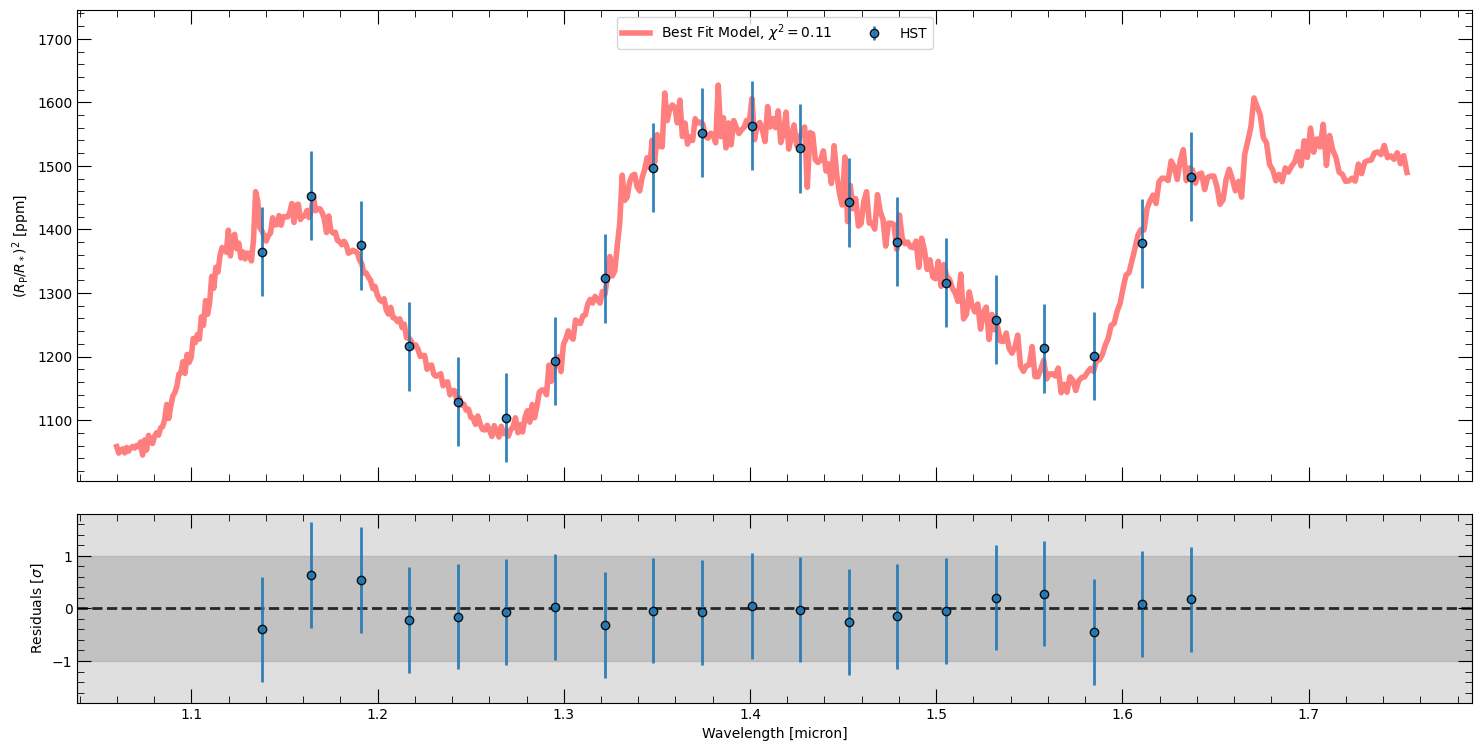

In [10]:
# Plotting the best fit spectrum
# This will generate a few warnings, but it's fine.
fig,ax,ax_r = retrieval.plot_spectra(
    samples_use, parameters_read, refresh=True, mode='bestfit'
)

### Pressure-Temperature profile
Here we show the retrieved pressure-temperature profile throughout the atmosphere. The contours show the 1, 2 and 3 sigma confidence intervals in temperature around the median retrieved profile.
If ``contribution=True``, the opacity shading and dashed line show the region of the atmosphere that contributes to the observed spectrum, highlighting which part of the pressure profile is being probed.


Plotting PT profiles


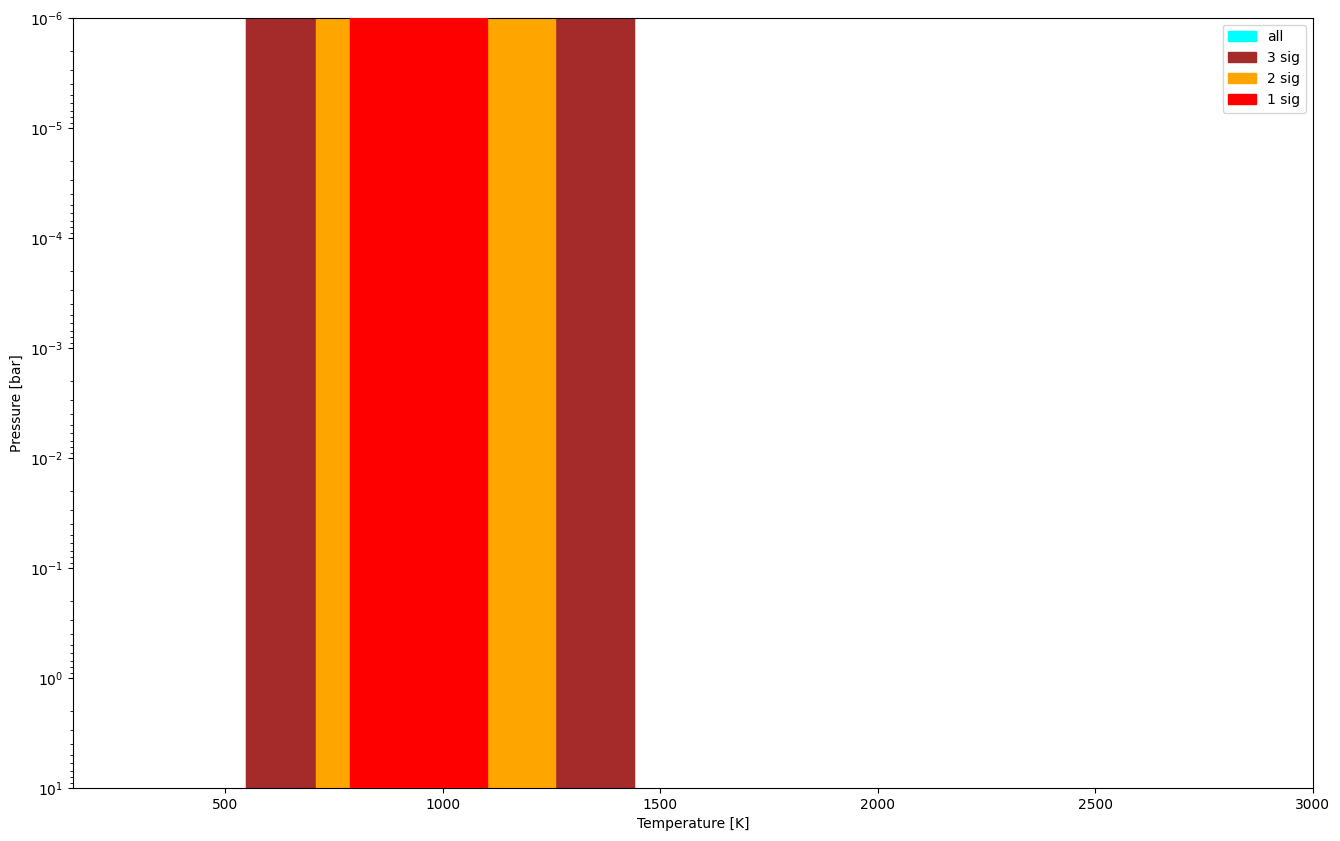

In [11]:
# Plotting the PT profile
fig, ax = retrieval.plot_pt(sample_dict,parameters_read, contribution=False)

### Corner plot
Here we show the corner plot for the retrieval, which shows the marginal posterior probability distributions for each parameter (though it is also possibe to plot only a subset of the parameters).
The corner plot produces 1, 2 and 3 sigma contours for the 2D plots, and highlights the 1 sigma confidence interval in the histograms for each parameter.
Optional, there are several kwarg parameters that can be used to customise the plotting aesthetics.


Making corner plot


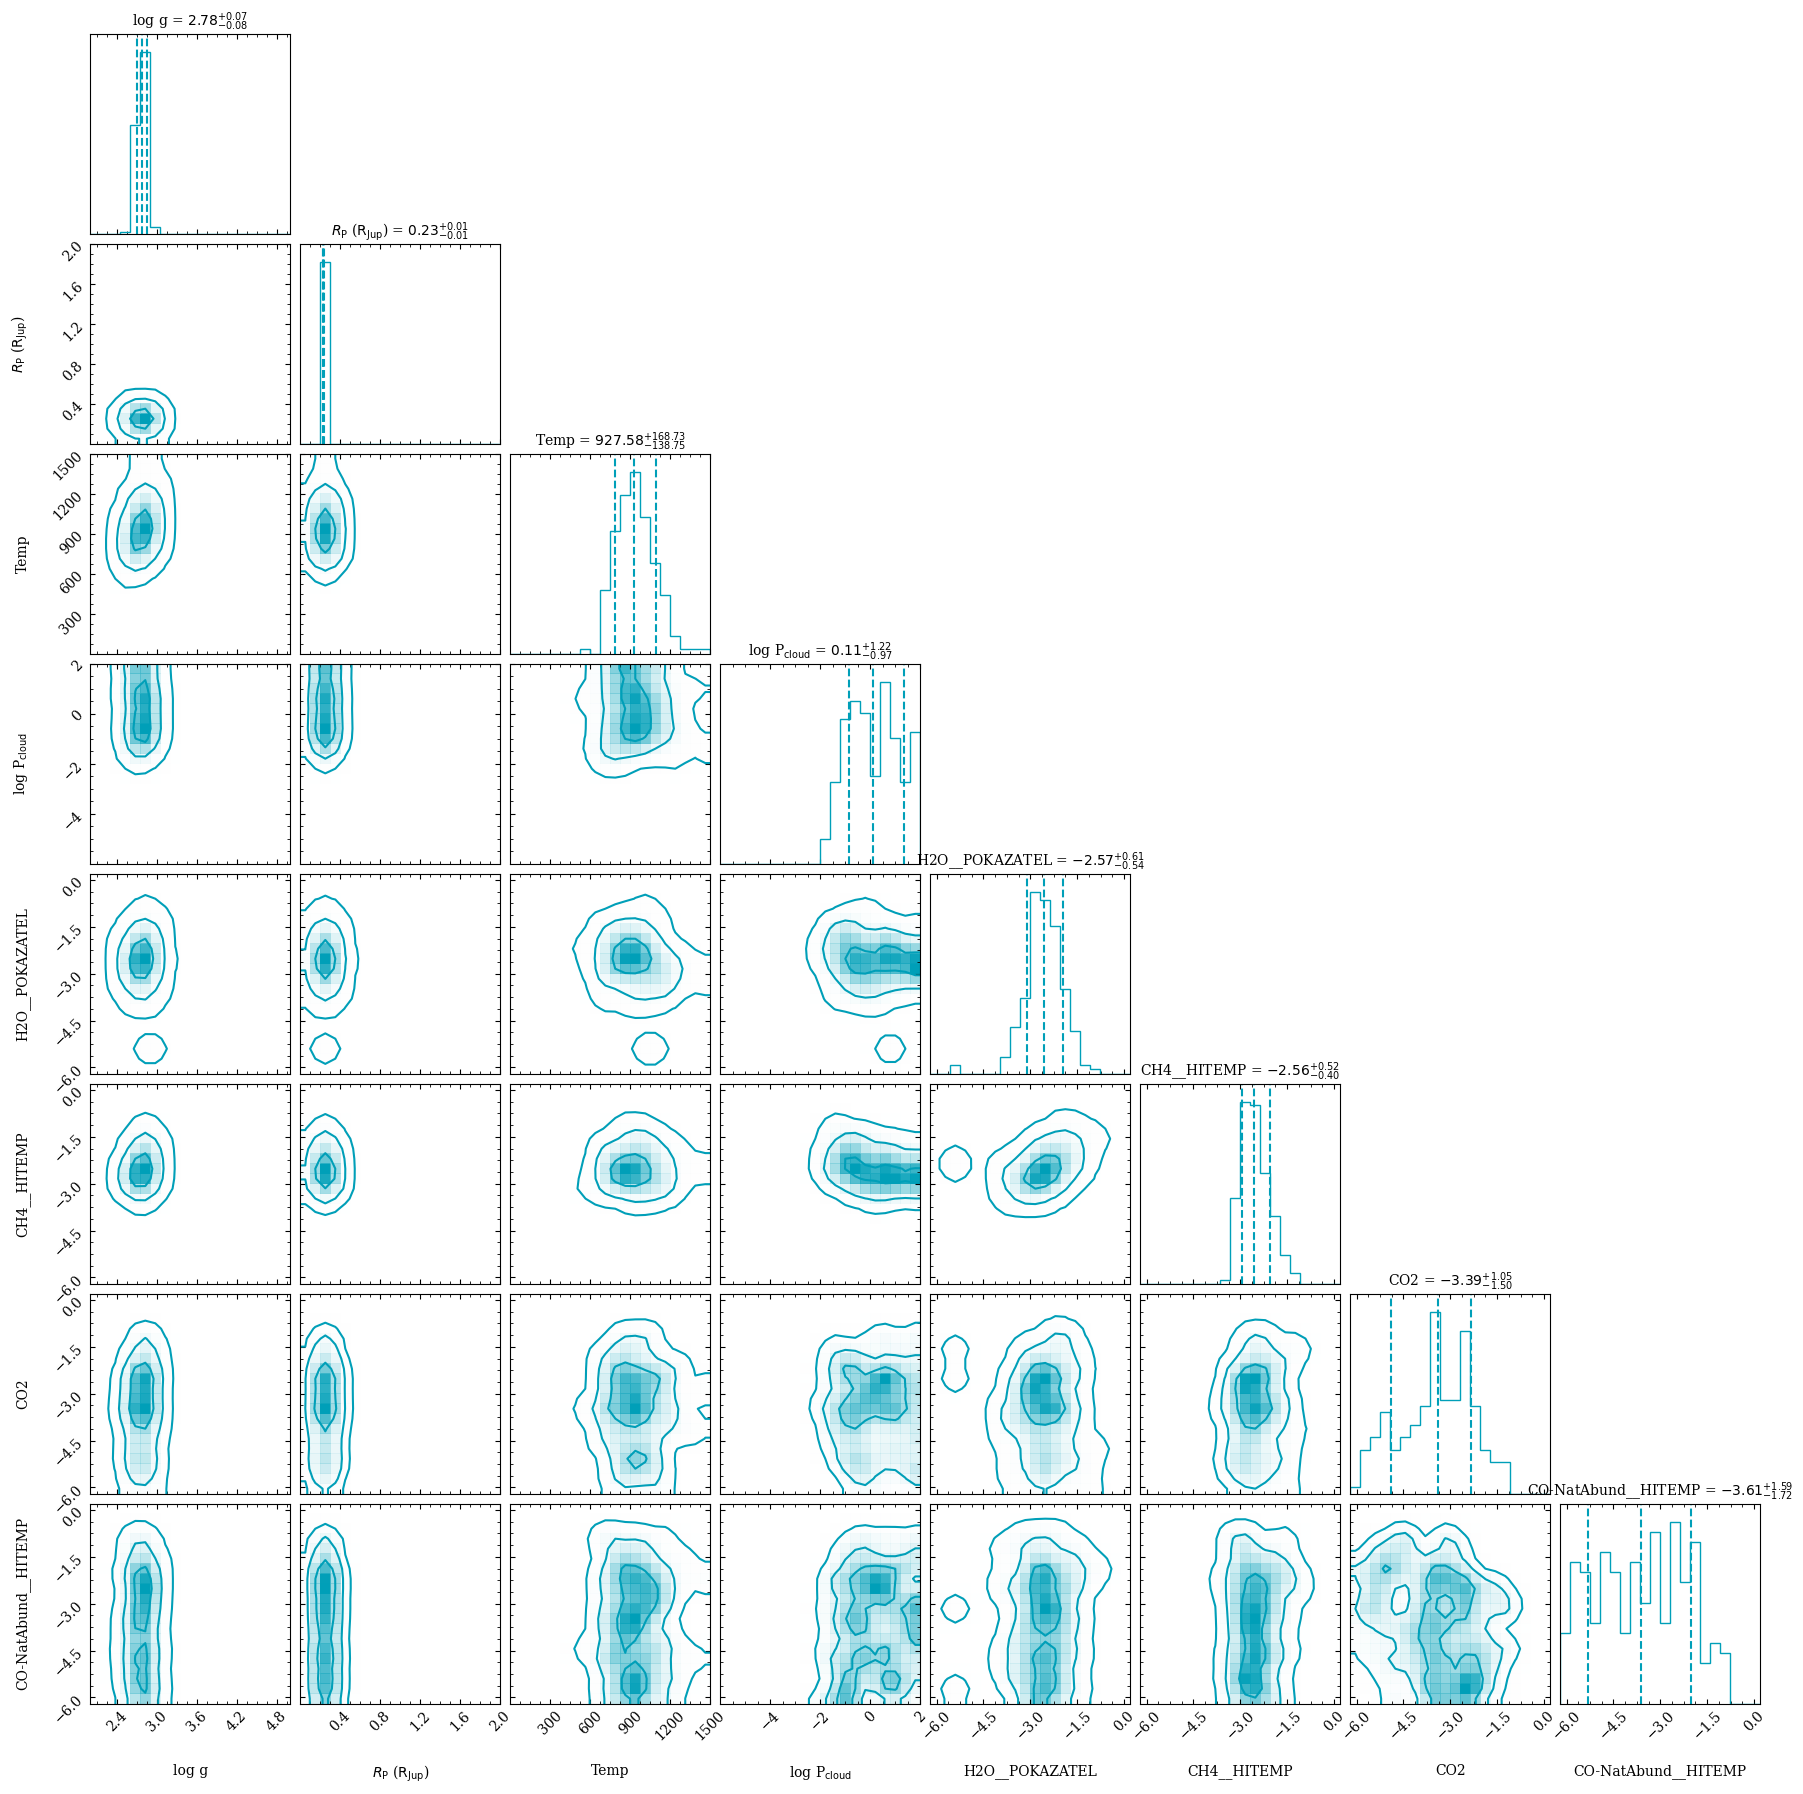

In [12]:
# Corner plot
# The corner plot produces 1,2 and 3 sigma contours for the 2D plots
retrieval.plot_corner(sample_dict, parameter_dict, parameters_read, title_kwargs={"fontsize" : 10}, smooth=1)

Note that all plots, but also additional files (including the best-fit spectrum at high-resolution, so $\lambda/\Delta\lambda=1000$, regardless of what your model resolution for the retrieval was), will also be put into the ``evaluate_hst_example_clear_spec`` folder.

### Plot everything at once

It is possible to plot every figures at once using the `plot_all` function. However, control on the figures is limited.

In [13]:
retrieval.plot_all(contribution=True)

Best fit parameters
Best fit likelihood = 172.32
log_g 2.74209718736825
planet_radius 1635752360.22101
temperature 852.6696022849248
log_Pcloud 1.8713243922076401
H2O__POKAZATEL -2.4379260627288124
CH4__HITEMP -2.672435452971601
CO2 -5.615758586571792
CO-NatAbund__HITEMP -3.1393823614914034

Plotting Best-fit spectrum
Best fit likelihood = 172.32
Loading Radtrans opacities...
 Loading line opacities of species 'H2O__POKAZATEL' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4__HITEMP' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loadi

/mnt/c/Users/doria/OneDrive/Documents/programs/Python/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:4374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Plotting PT profiles
Best fit likelihood = 172.32
Loading Radtrans opacities...
 Loading line opacities of species 'H2O__POKAZATEL' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4__HITEMP' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund__HITEMP' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file


Plotting Best-fit contribution function
Best fit likelihood = 172.32
Loading best fit spectrum and contribution from file

Plotting Abundances profiles
Best fit likelihood = 172.32
Loading best fit spectrum and contribution from file
Finished generating all plots!


**Contact**

If you need any additional help, don't hesitate to contact [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals).